In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import scanpy as sc
import pandas as pd
import scanpy as sc 
import sys 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib as mpl

warnings.filterwarnings('ignore')
sys.path.append('../../src')

from spaceoracle.plotting.cartography import Cartography
import celloracle as co
from celloracle.applications import Gradient_calculator
from celloracle.applications.scatter_to_grid import scatter_value_to_grid_value
from celloracle.applications.differentiation_flow import get_gradient, normalize_gradient
from spaceoracle.virtual_tissue import VirtualTissue

In [3]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')
adata.obsm['X_umap'] = pd.read_csv('../../notebooks/human_tonsil/umap.csv', index_col=0).values
adata.obs = adata.obs.join(pd.read_csv('../../notebooks/human_tonsil/tonsil_cell_types.csv', index_col=0))

sc.pp.pca(adata)
sc.pp.neighbors(adata)

adata.layers['imputed_count'] = np.load('../../notebooks/human_tonsil/imputed_counts.npy')

In [4]:
import json

with open('./colors.json', 'r') as f:
    color_dict = json.load(f)

In [5]:
adata.obs['cell_type_major'] = adata.obs.cell_type_2.replace(
    {
        'GC Dark Zone': 'Germinal Center B cells', 
        'GC Light Zone': 'Germinal Center B cells', 
        'GC Intermediate Zone': 'Germinal Center B cells', 
        'plasma': 'Plasma cells', 
        'B_naive': 'B cells', 
        'B_memory': 'B cells', 
        'B_germinal_center': 'Germinal Center B cells', 
        'Naive CD4 T': 'T cells', 
        'Treg': 'T cells', 
        'T memory': 'T cells', 
        'Th1': 'T cells', 
        'Th2': 'T cells', 
        'T_CD8': 'T cells', 
        'T_follicular_helper': 'T cells', 
        'mDC': 'Dendritic cells', 
        'FDC': 'Dendritic cells', 
        'myeloid': 'Myeloid cells', 
        'NK': 'NK cells', 
        'pDC': 'Dendritic cells', 
        'T_double_neg': 'T cells'
    }
)

In [6]:
%matplotlib inline

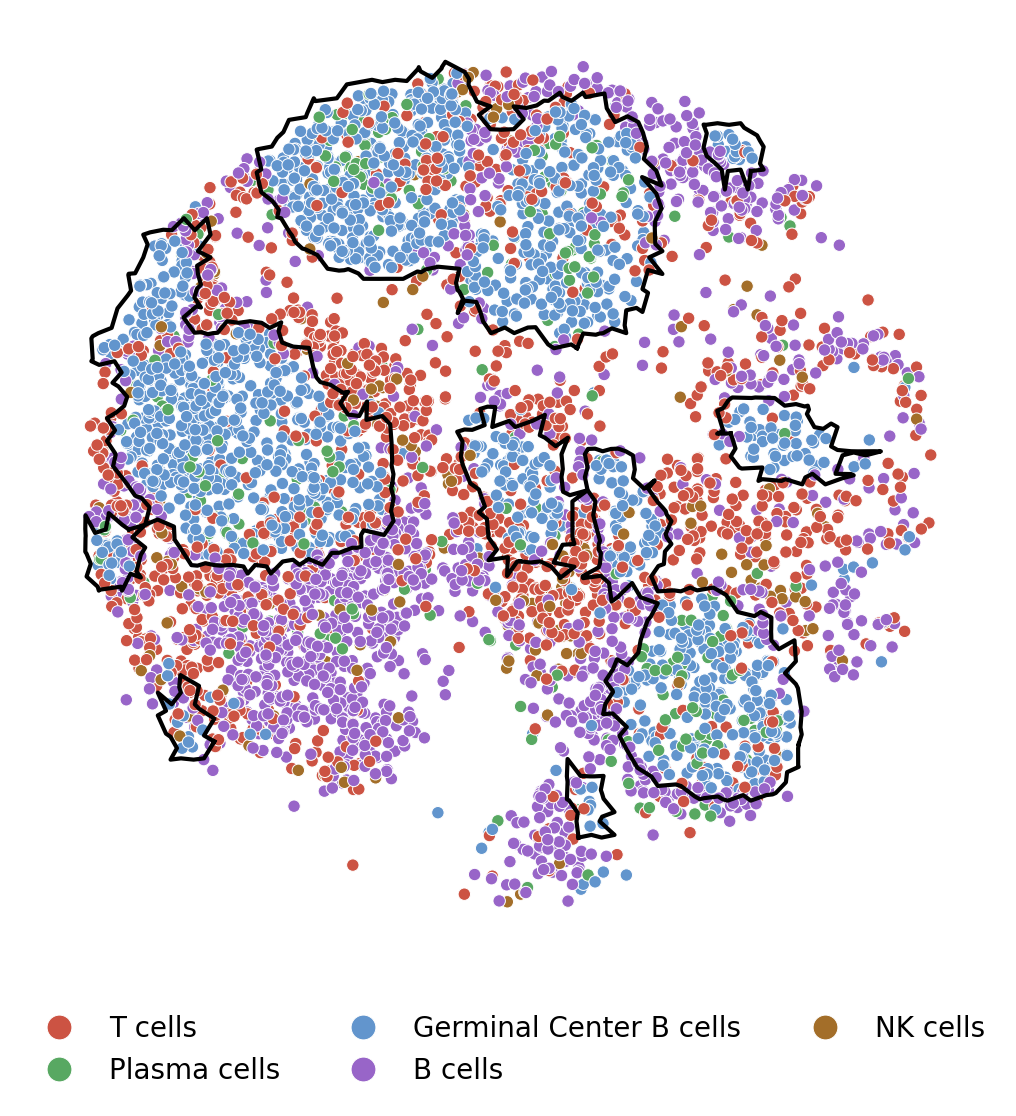

In [7]:
plt.rcParams['figure.figsize'] = (6, 6)

import alphashape

ct_points_wt = {}
for ct in adata.obs['cell_type_major'].unique():
    points = np.asarray(
        adata[adata.obs['cell_type_major'] == ct].obsm['spatial'])
    delta = 30
    points = np.vstack(
        (points +[-delta,delta], points +[-delta,-delta], 
        points +[delta,delta], points +[delta,-delta]))
    ct_points_wt[ct] = points

adatax = adata[~adata.obs.cell_type_major.isin([
    'Myeloid cells', 'Dendritic cells'])]
sns.scatterplot(data=adatax.obs, 
    x=adatax.obsm['spatial'][:,0], 
    y=adatax.obsm['spatial'][:,1],
    s=20,
    hue='cell_type_major',
    legend='brief', palette=color_dict)
plt.axis('off')

alpha_shape = alphashape.alphashape(ct_points_wt['Germinal Center B cells'], alpha=0.035)
for geom in alpha_shape.geoms:
    if geom.area > 10000:
        plt.plot(
            geom.exterior.xy[0], 
            geom.exterior.xy[1], 
            color='black', alpha=1)
plt.legend(bbox_to_anchor=(0.5, -0.05), 
    loc='upper center', ncol=3, frameon=False, 
    markerscale=2, fontsize=10)
plt.savefig('tonsil_celltypes.svg', dpi=300, bbox_inches='tight', format='svg', transparent=True)
plt.show()

... storing 'cell_type_2' as categorical
... storing 'cell_type_major' as categorical


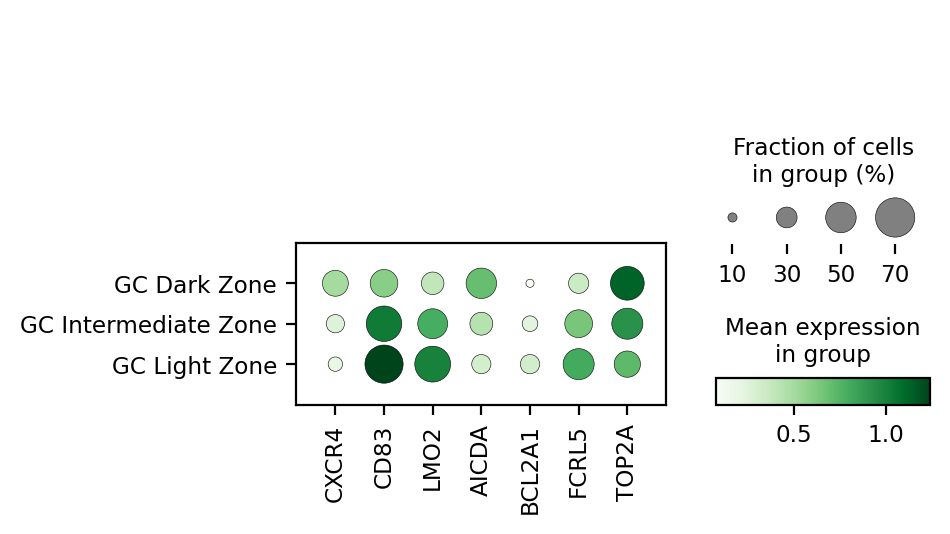

In [8]:
sc.pl.dotplot(adata[adata.obs.cell_type_2.str.contains('GC')], 
    var_names=['CXCR4', 'CD83', 'LMO2', 'AICDA', 'BCL2A1', 'FCRL5', 'TOP2A'], 
    groupby='cell_type_2', layer='normalized_count', cmap='Greens', show=False)

plt.savefig('dotplot_GC.svg', dpi=300, bbox_inches='tight', format='svg', transparent=True)

In [9]:
tonsil = VirtualTissue(
    adata = adata,
    annot = 'cell_type_2',
    betadatas_path = '/Volumes/SSD/lasso_runs/human_tonsil',
    ko_path = '/Volumes/SSD/genome_screens/human_tonsil',
    color_dict=color_dict
)

rename={
    'T_follicular_helper': 'T Follicular\nHelper',
    'T_CD8': 'T CD8+',
    'T_CD4': 'T CD4+',
    'B_germinal_center': 'B Germinal\nCenter',
    'B_naive': 'B\nNaive',
    'B_memory': 'B\nMemory',
}

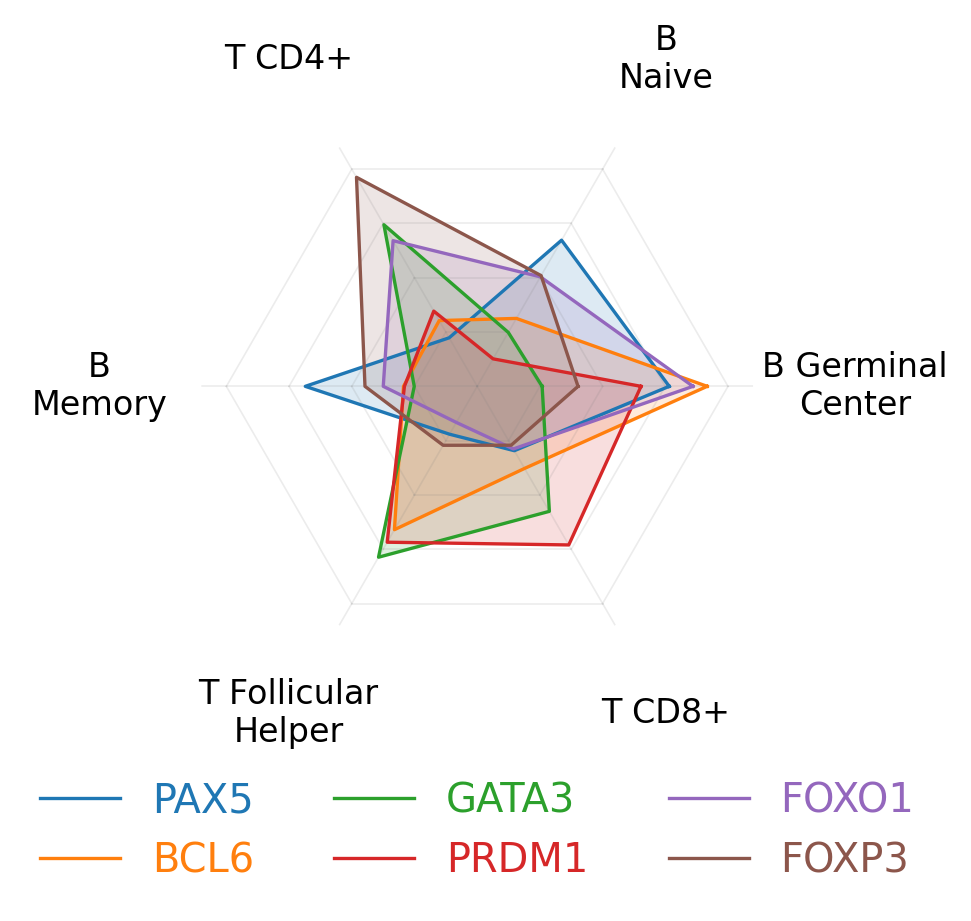

In [10]:
%matplotlib inline
tonsil.plot_radar(genes=[['PAX5', 'BCL6',  'GATA3', 'PRDM1', 'FOXO1', 'FOXP3']], 
    show_for=['B_germinal_center', 'B_naive', 'T_CD4', 
    'B_memory', 'T_follicular_helper', 'T_CD8'], 
    cache_path='../../notebooks/human_tonsil/', 
    figsize=(10, 4),
    dpi=120,
    rename=rename)

plt.savefig('spider_plot_tf.svg', dpi=300, bbox_inches='tight', format='svg', transparent=True)
plt.show()

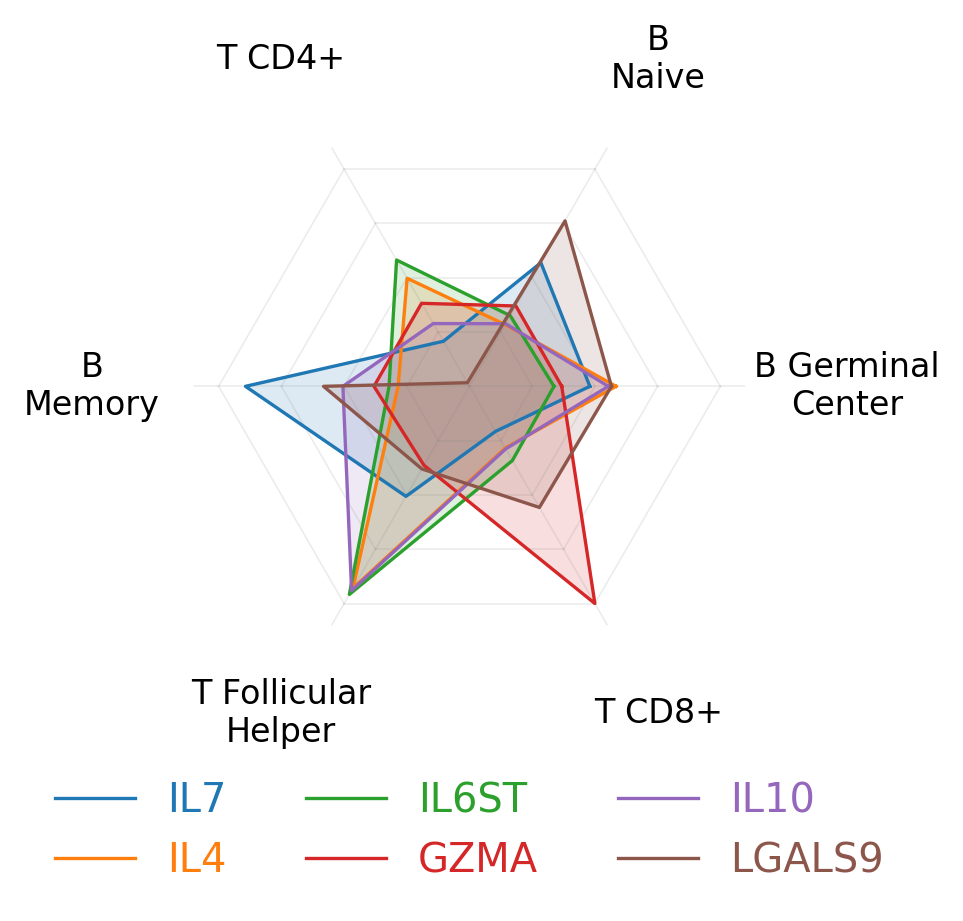

In [11]:
%matplotlib inline
tonsil.plot_radar(genes=[['IL7', 'IL4',  'IL6ST', 'GZMA', 'IL10', 'LGALS9']], 
    show_for=['B_germinal_center', 'B_naive', 'T_CD4', 
    'B_memory', 'T_follicular_helper', 'T_CD8'], 
    cache_path='../../notebooks/human_tonsil/', 
    figsize=(10, 4),
    dpi=120,
    rename=rename)

plt.savefig('spider_plot_ligands.svg', dpi=300, bbox_inches='tight', format='svg', transparent=True)
plt.show()

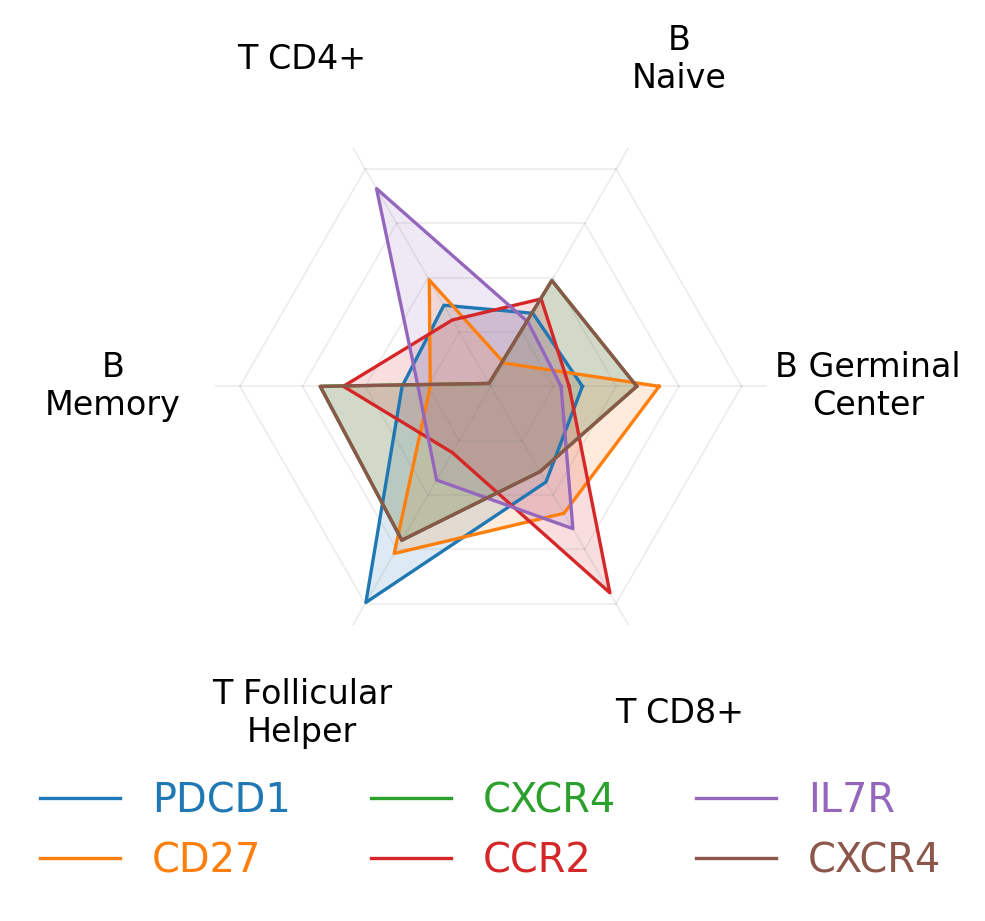

In [12]:
%matplotlib inline
tonsil.plot_radar(genes=[['PDCD1', 'CD27',  'CXCR4', 'CCR2', 'IL7R', 'CXCR4']], 
    show_for=['B_germinal_center', 'B_naive', 'T_CD4', 
    'B_memory', 'T_follicular_helper', 'T_CD8'], 
    cache_path='../../notebooks/human_tonsil/', 
    figsize=(10, 4),
    dpi=120,
    rename=rename)

plt.savefig('spider_plot_receptors.svg', dpi=300, bbox_inches='tight', format='svg', transparent=True)
plt.show()

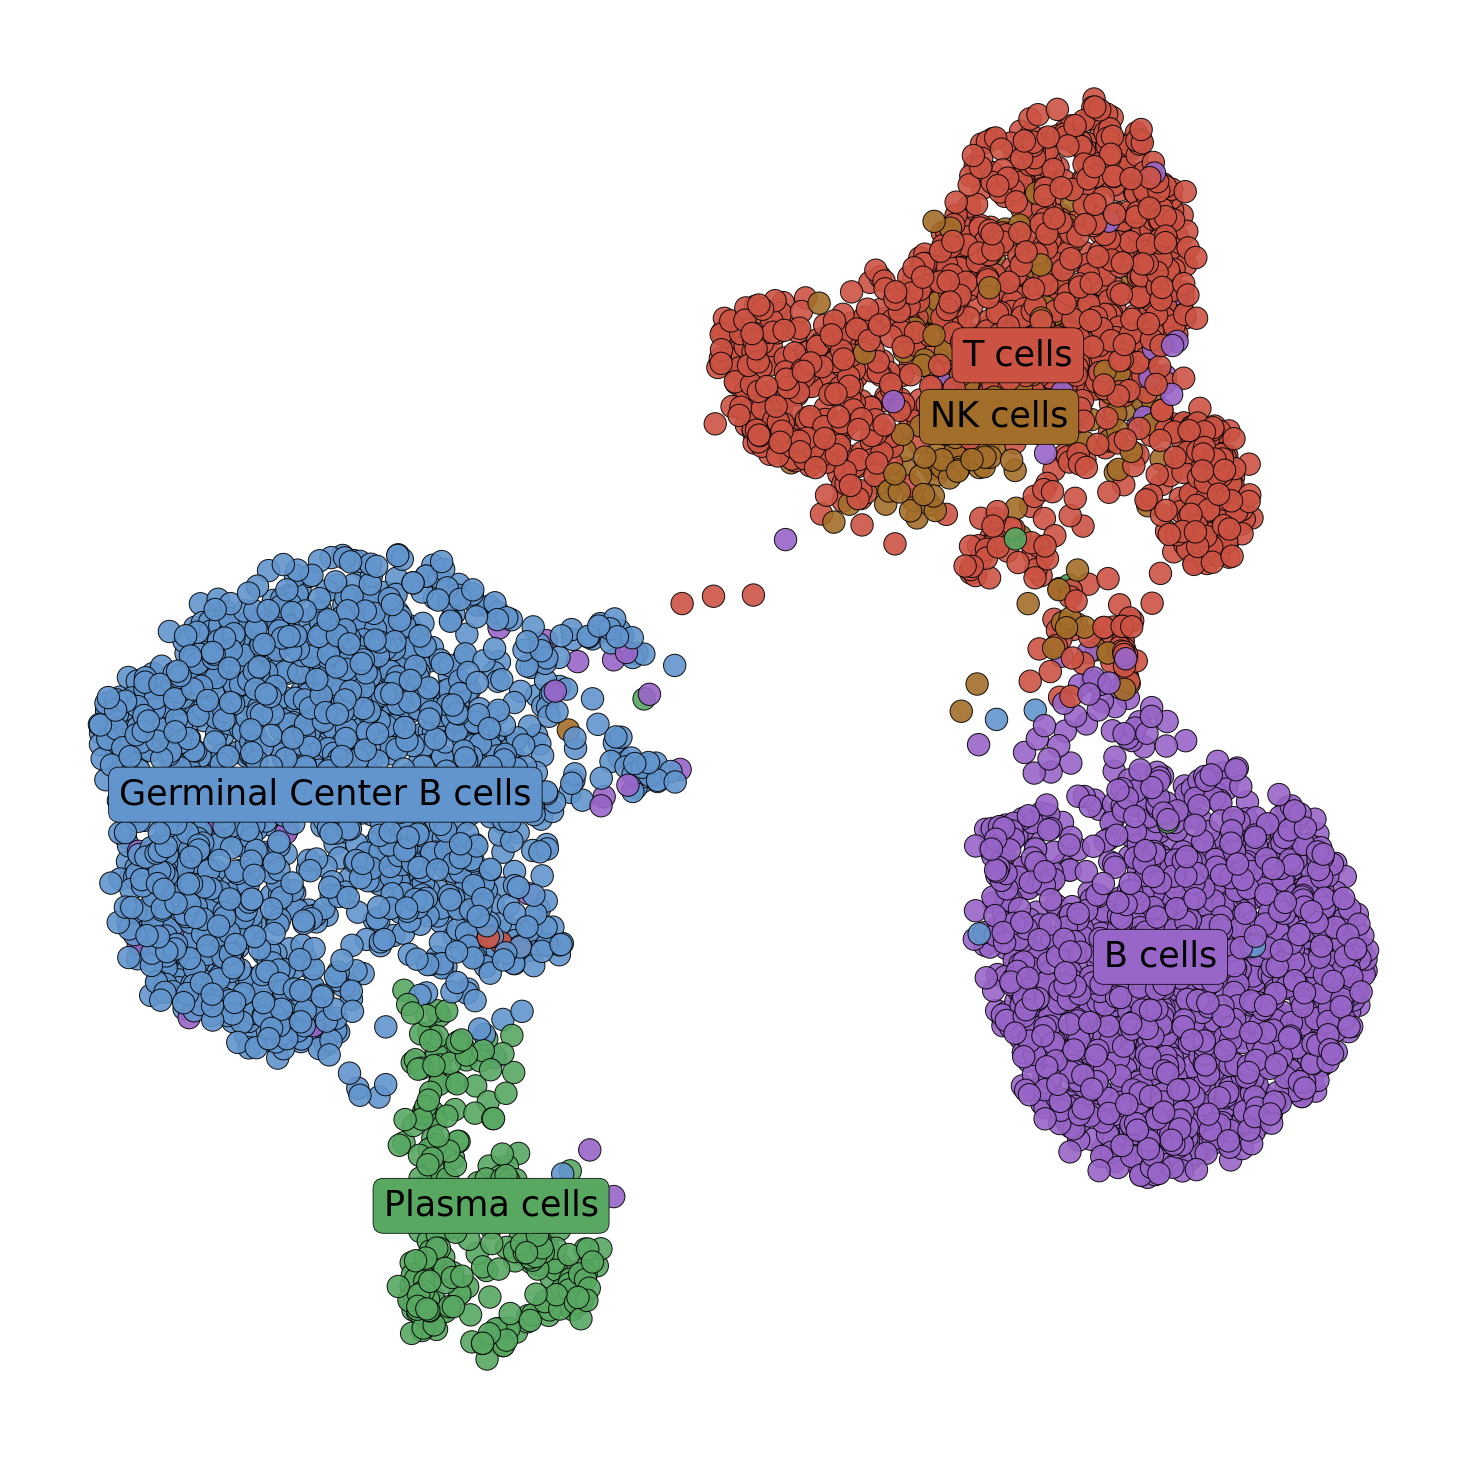

In [13]:
tonsil.init_cartography(adata[~adata.obs.cell_type_major.isin([
    'Myeloid cells', 'Dendritic cells'])])

tonsil.chart.plot_umap(
    hue='cell_type_major',
    color_dict=color_dict,
    scatter_size=20,
    linewidth=0.2,
    legend_fontsize=7,
)
plt.savefig('tonsil_umap.svg', dpi=300, format='svg', bbox_inches='tight', transparent=True)

In [14]:
atmp = adata[~adata.obs.index.isin(adata.obs.iloc[[2250, 2593, 3255, 5281]].index)]
# atmp = adata[pd.read_csv('GC_selection.csv', index_col=0).index]
# atmp = adata
tonsil.init_cartography(atmp, 
    restrict_to=[
        'Naive CD4 T',
        'T_follicular_helper', 
        'Th2', 
        'Th1', 
        'Treg',
        'T_CD8',
        
        # 'T memory',
         
        # 'GC Light Zone',
        # 'GC Dark Zone',
        # 'GC Intermediate Zone',
        # 'B_naive',
        # 'B_memory',
        # 'plasma'
        
    ]
)

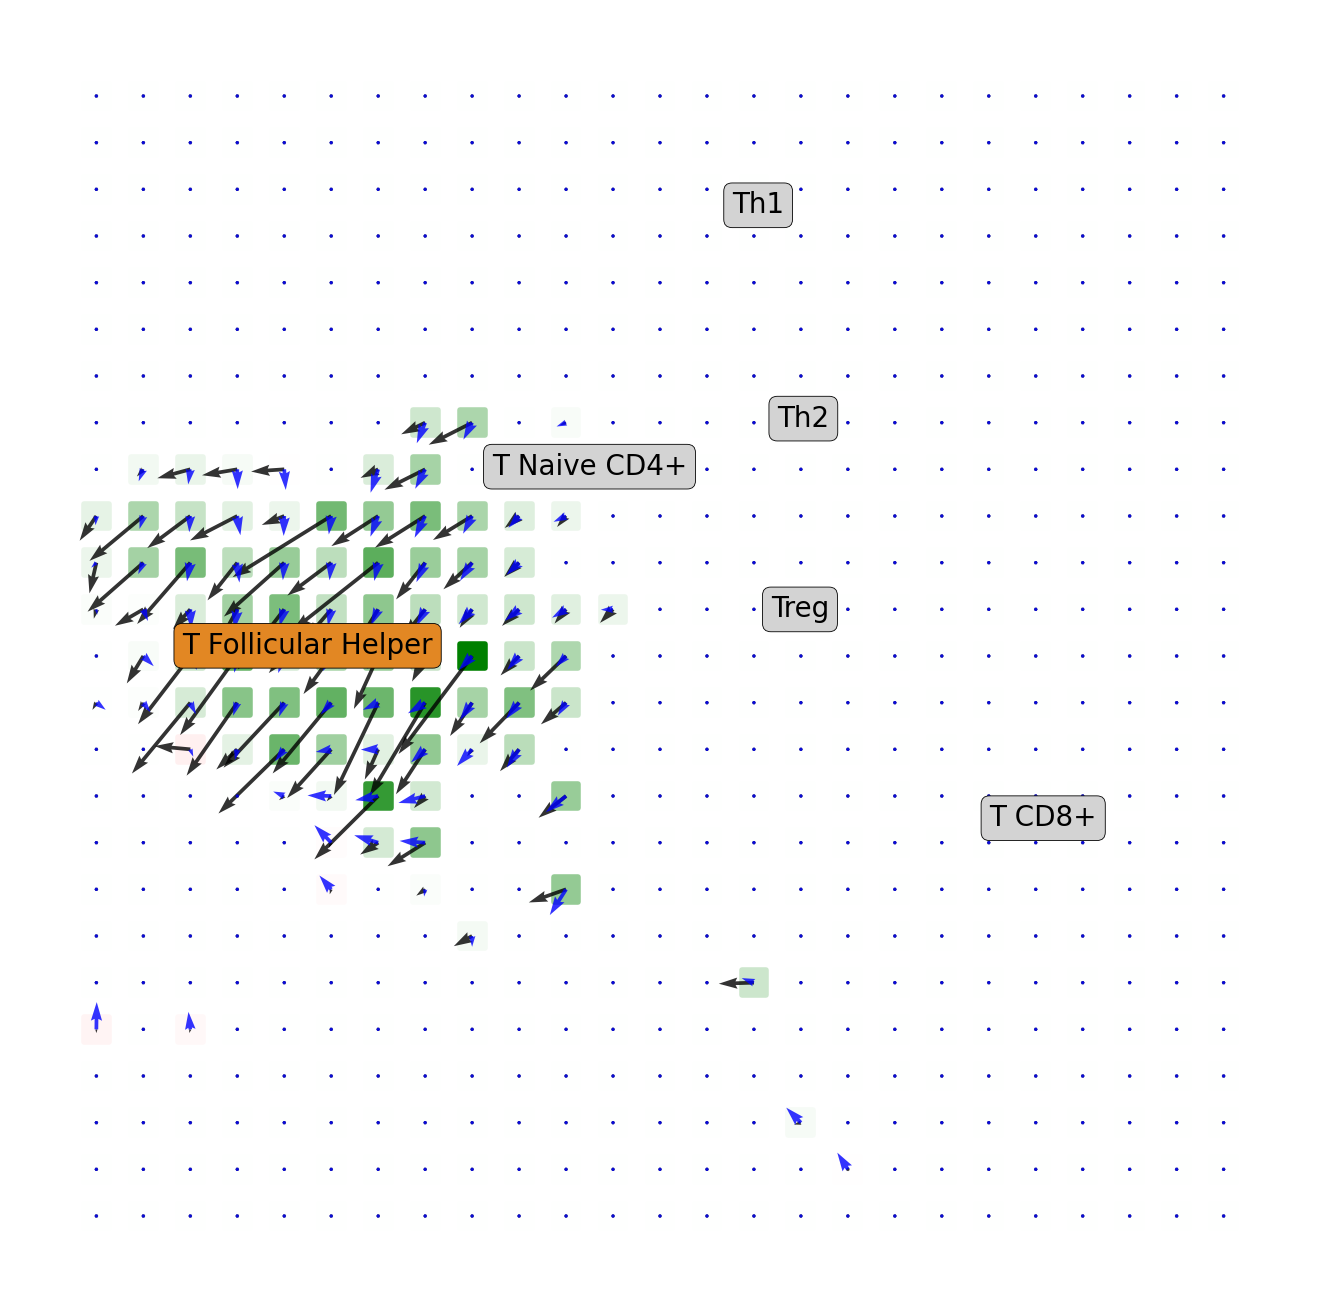

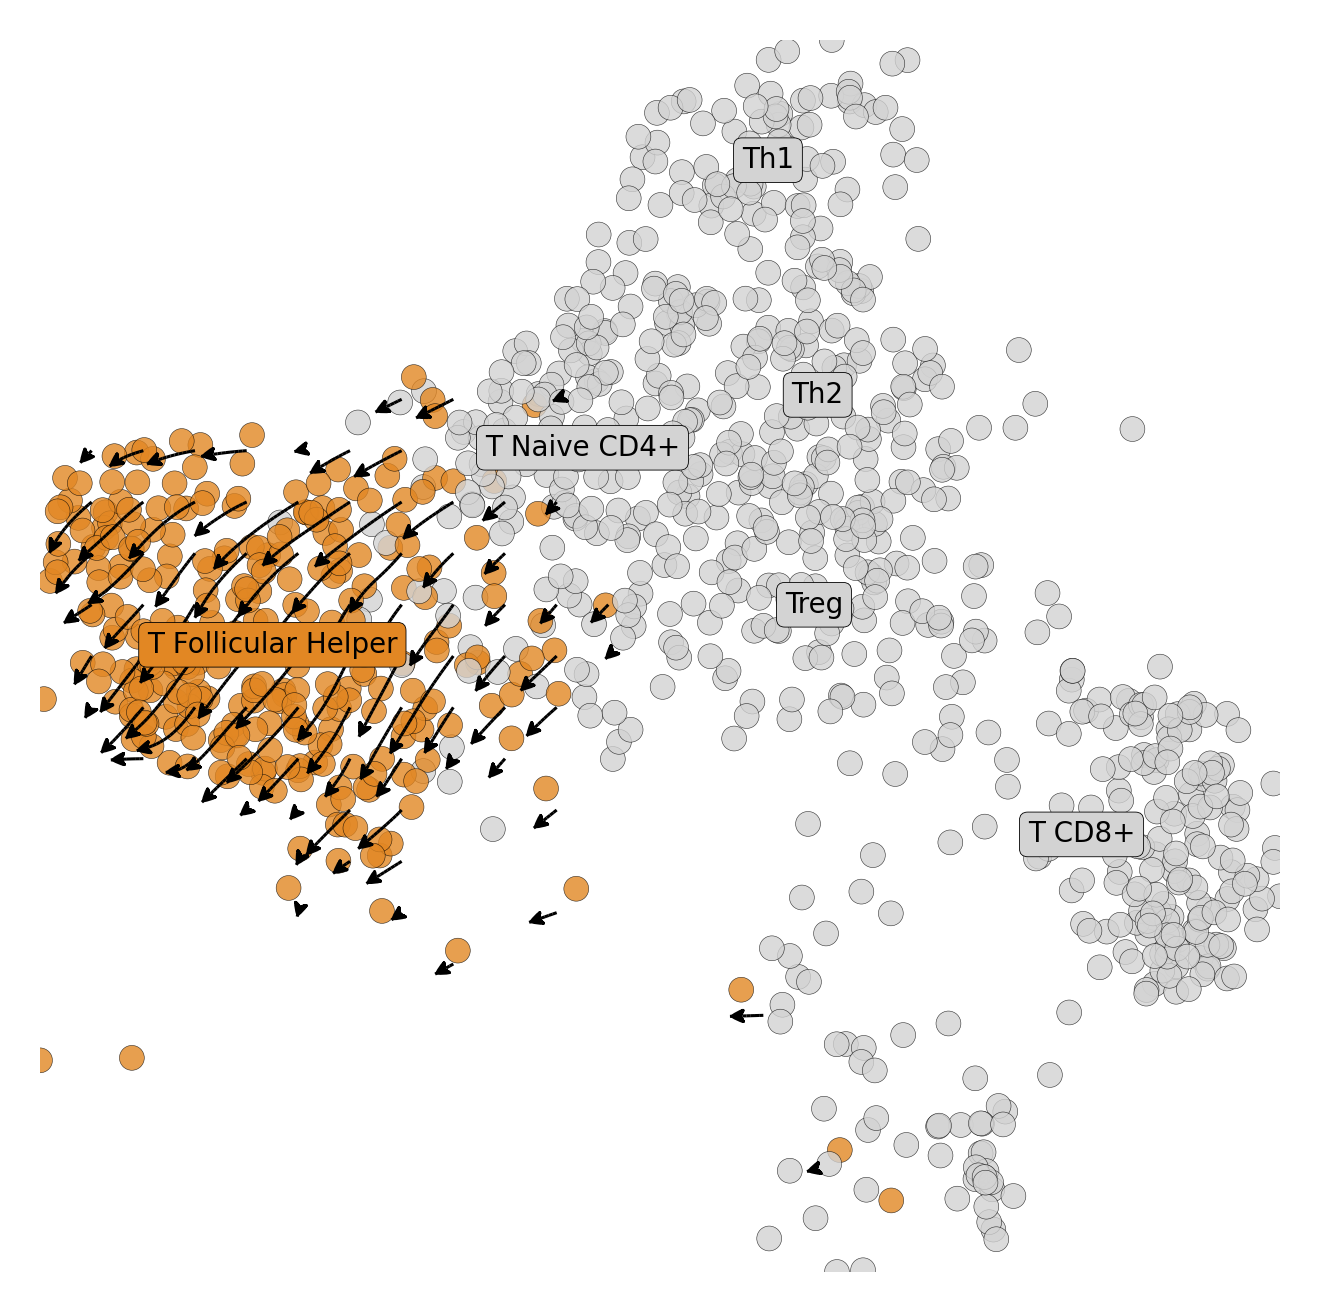

In [22]:
grid_points, vector_field = tonsil.plot_arrows_pseudotime(
    perturb_target='IL21', 
    perturbed_df=pd.read_parquet(
        '/Volumes/SSD/genome_screens/tonsil_special/IL21_OVX_T_follicular_helper.parquet'),
    # mode='max',
    mode='0',
    hue='cell_type_2',
    curve=True,
    vector_scale=0.02, 
    grid_scale=1,
    n_neighbors=160,
    scale=3, 
    grains=25,
    figsize=(4, 4),
    dpi=200,
    scatter_size=20,
    legend_fontsize=5,
    rename={
        'T_follicular_helper': 'T Follicular Helper',
        'T_CD8': 'T CD8+',
        'Naive CD4 T': 'T Naive CD4+',
    },
    iroot='Naive CD4 T',
    limit_clusters=True,
    highlight_clusters=[
        # 'Naive CD4 T',
        'T_follicular_helper', 
        # 'Th2', 
        # 'Th1', 
        # 'Treg',
        # 'T_CD8',
        # 'GC Light Zone',
        # 'GC Dark Zone',
        # 'GC Intermediate Zone',
        # 'B_memory',
        # 'B_naive',
        # 'plasma'
    ]
)

plt.savefig(
    'IL21_OVX_Tfh_pseudotime.svg', 
    dpi=300, 
    bbox_inches='tight', 
    format='svg', 
    transparent=True
)

plt.show()


grid_points, vector_field = tonsil.plot_arrows(
    perturb_target='IL21', 
    perturbed_df=pd.read_parquet(
        '/Volumes/SSD/genome_screens/tonsil_special/IL21_OVX_T_follicular_helper.parquet'),
    # mode='max',
    mode='0',
    hue='cell_type_2',
    curve=True,
    vector_scale=0.02, 
    grid_scale=1,
    n_neighbors=160,
    scale=3, 
    grains=25,
    figsize=(4, 4),
    dpi=200,
    scatter_size=20,
    legend_fontsize=5,
    rename={
        'T_follicular_helper': 'T Follicular Helper',
        'T_CD8': 'T CD8+',
        'Naive CD4 T': 'T Naive CD4+',
    },
    limit_clusters=True,
    highlight_clusters=[
        # 'Naive CD4 T',
        'T_follicular_helper', 
        # 'Th2', 
        # 'Th1', 
        # 'Treg',
        # 'T_CD8',
        # 'GC Light Zone',
        # 'GC Dark Zone',
        # 'GC Intermediate Zone',
        # 'B_memory',
        # 'B_naive',
        # 'plasma'
    ]
)

plt.savefig(
    'IL21_OVX_Tfh.svg', 
    dpi=300, 
    bbox_inches='tight', 
    format='svg', 
    transparent=True
)

plt.show()

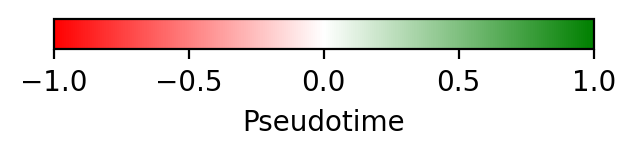

In [23]:
fig = plt.figure(figsize=(3, 1), dpi=100)
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cmap = LinearSegmentedColormap.from_list('custom', ['red', 'white', 'green'])
norm = mpl.colors.Normalize(vmin=-1, vmax=1)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Pseudotime')
plt.savefig('pseudotime_colorbar.svg', dpi=300, bbox_inches='tight', format='svg', transparent=True)
plt.show()

In [24]:
atmp = adata[~adata.obs.index.isin(adata.obs.iloc[[2250, 2593, 3255, 5281]].index)]

In [25]:
atmp = atmp[atmp.obs.cell_type_2.isin([
        'Naive CD4 T',
        'T_follicular_helper', 
        'Th2', 
        'Th1', 
        'Treg',
        # 'T_CD8',
    ])]

In [46]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/snrna_human_tonsil.h5ad')
adata.obsm['X_umap'] = pd.read_csv('../../notebooks/human_tonsil/umap.csv', index_col=0).values
adata.obs = adata.obs.join(pd.read_csv('../../notebooks/human_tonsil/tonsil_cell_types.csv', index_col=0))
sc.pp.pca(adata)
sc.pp.neighbors(adata)
adata.layers['imputed_count'] = np.load('../../notebooks/human_tonsil/imputed_counts.npy')

In [55]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['cell_type_2'] == 'T_follicular_helper')[0]
sc.tl.diffmap(adata)
sc.tl.dpt(adata, n_dcs=10, n_branchings=0)

... storing 'cell_type_2' as categorical


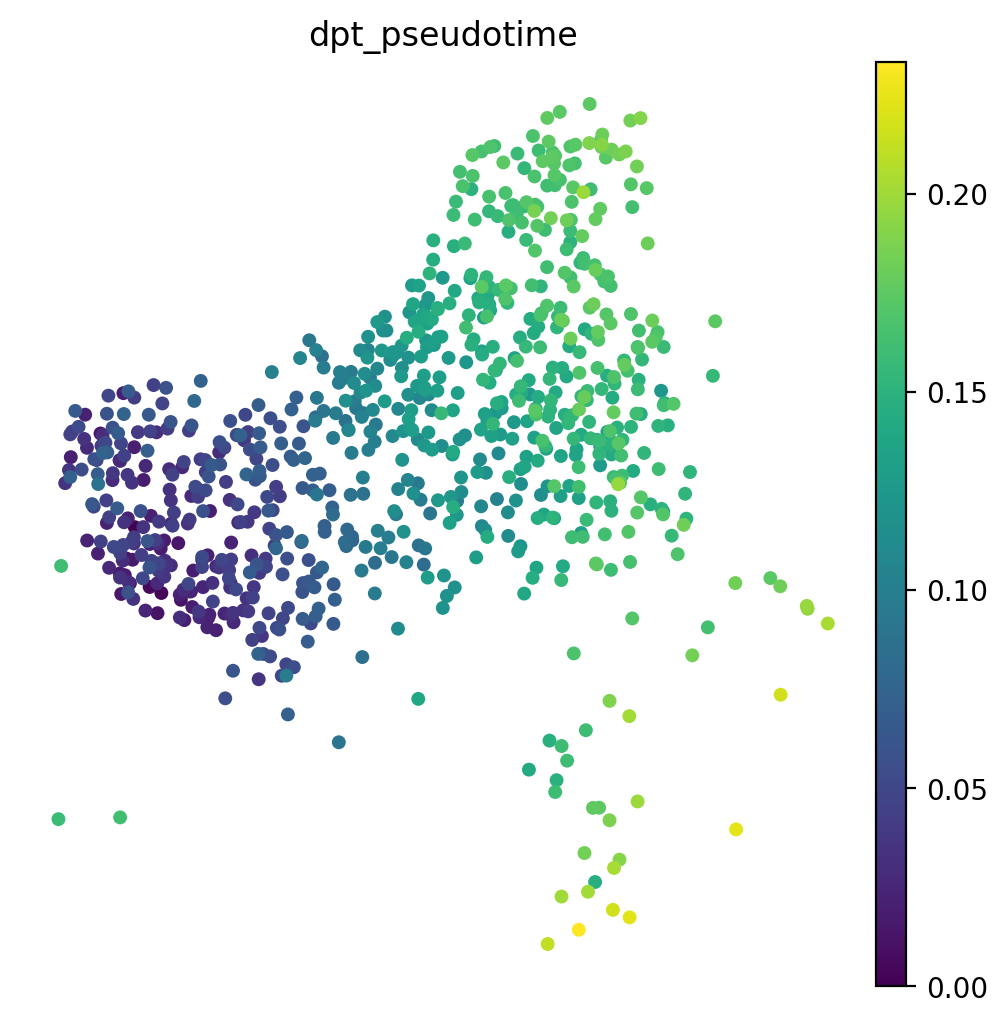

In [56]:
sc.pl.umap(adata[atmp.obs_names], color=['dpt_pseudotime'], size=100, frameon=False)

In [321]:
from celloracle.applications.differentiation_flow import get_gradient, normalize_gradient
import random
from spaceoracle.virtual_tissue import VirtualTissue

from sklearn.neighbors import KNeighborsRegressor

def _knn_regression(x, y, x_new, y_new, value, n_knn=30):

    data = np.stack([x, y], axis=1)

    model = KNeighborsRegressor(n_neighbors=n_knn)
    model.fit(data, value)

    data_new = np.stack([x_new, y_new], axis=1)

    return model.predict(data_new)

In [349]:
embedding = adata.obsm['X_umap']
x, y = embedding[:, 0], embedding[:, 1]
x_new, y_new = grid_points[:, 0], grid_points[:, 1]

value = adata.obs.dpt_pseudotime.values
# value = tonsil.load_betadata(gene='IL21')['beta_FOXP3'].values

pseudotime_on_grid = _knn_regression(x, y, x_new, y_new, value, n_knn=30)
gradient = get_gradient(value_on_grid=pseudotime_on_grid)
gradient = normalize_gradient(gradient, method="sqrt")
l2_norm = np.linalg.norm(gradient, ord=2, axis=1)
scale_factor = 1 / l2_norm.mean()
ref_flow = gradient * 2

zero_mask = (vector_field[:,0] == 0) & (vector_field[:,1] == 0)
ref_flow[zero_mask] = 0

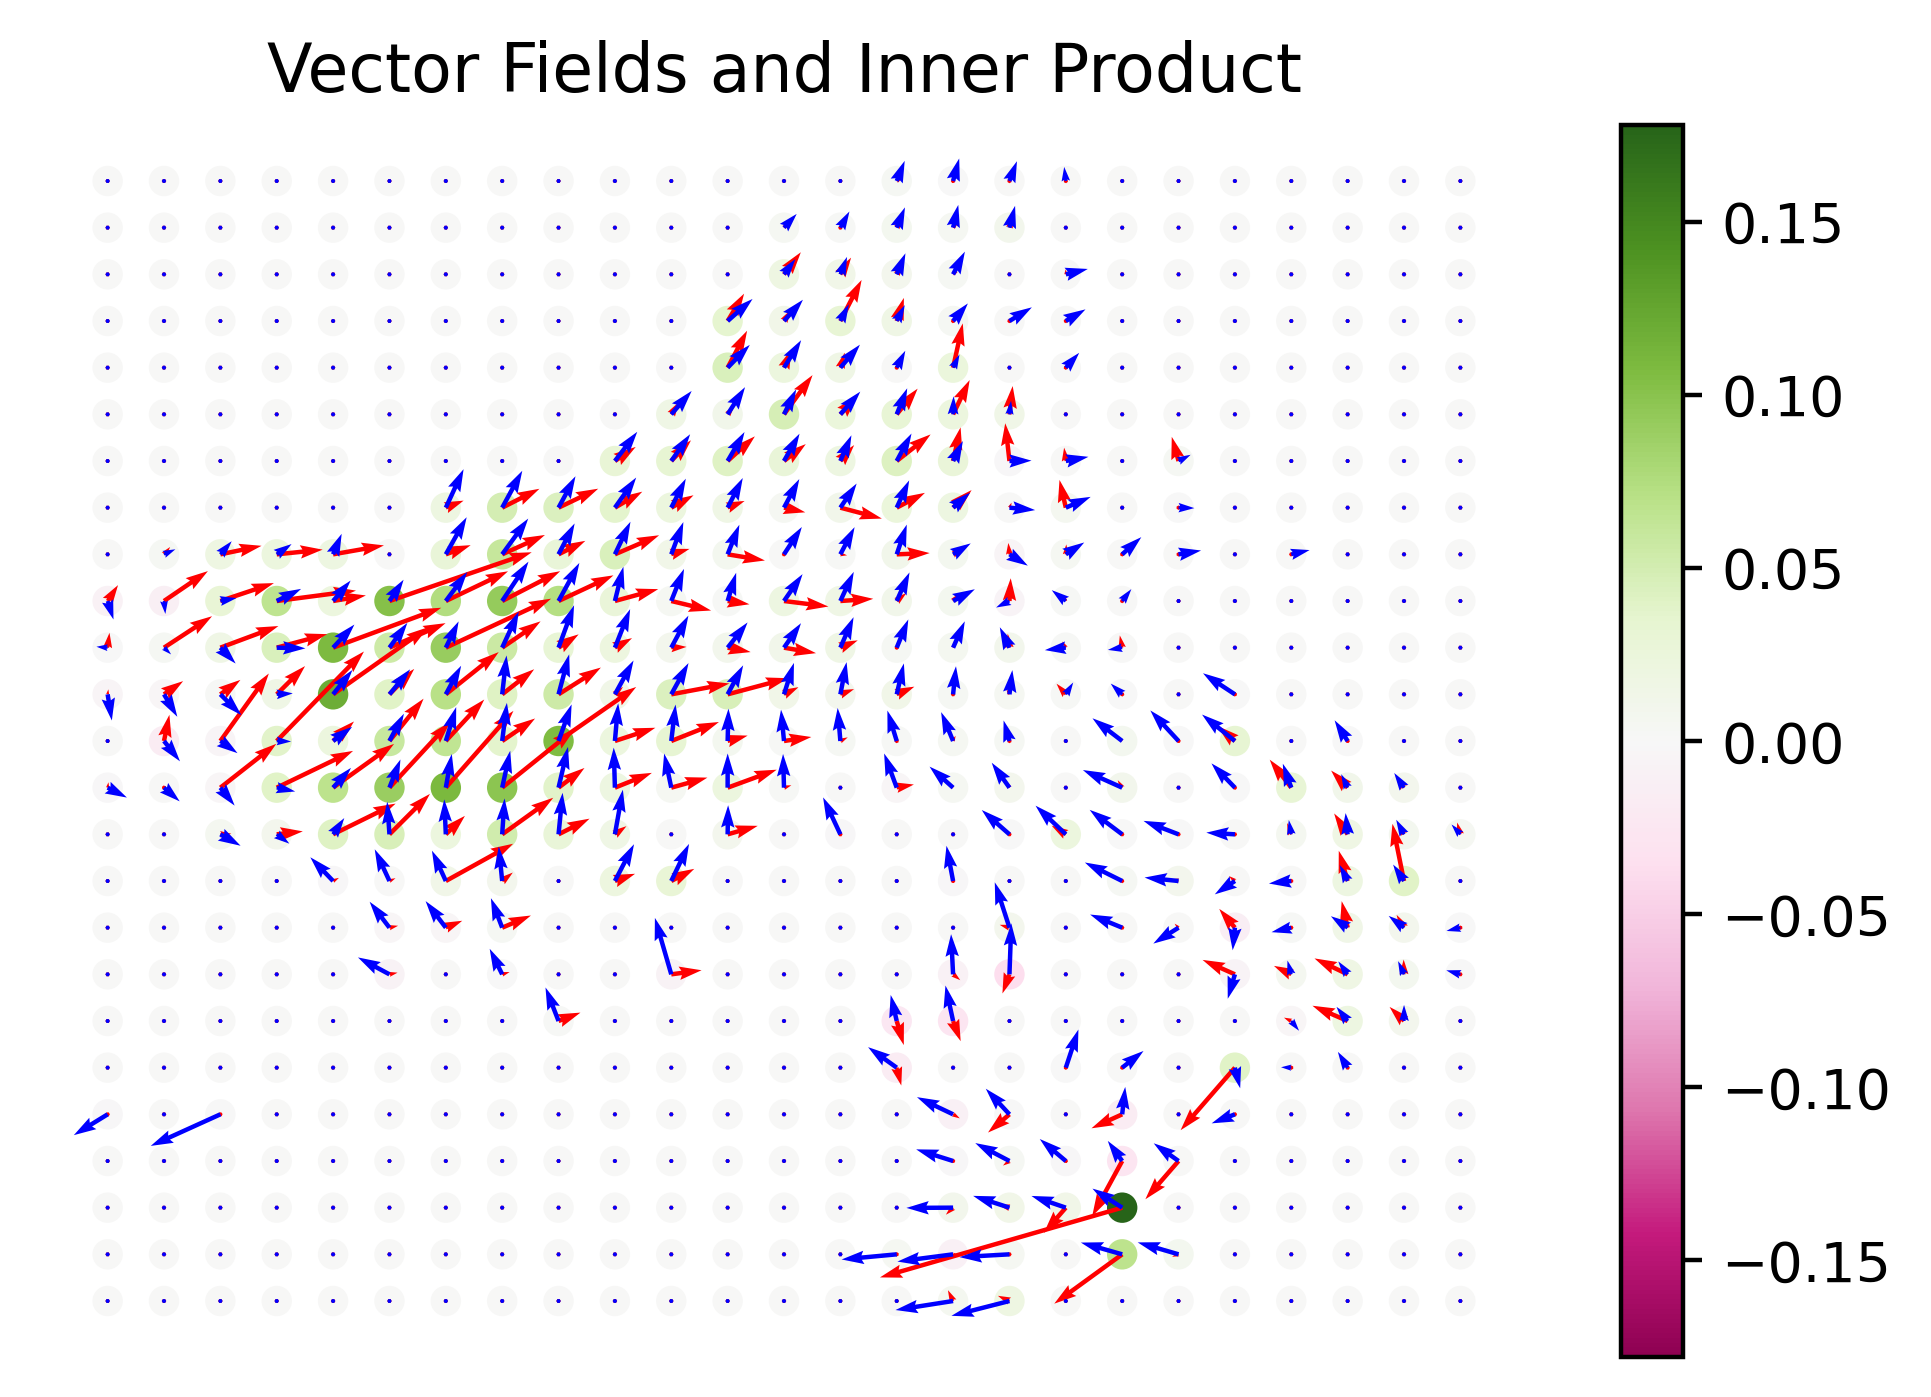

In [350]:
inner_product = np.sum(vector_field * ref_flow, axis=1)
fig, ax = plt.subplots(figsize=(6, 4), dpi=200)
vmax = np.abs(inner_product).max()
scatter = ax.scatter(grid_points[:,0], grid_points[:,1], 
                    c=inner_product, cmap='PiYG', s=20,
                    vmin=-vmax, vmax=vmax)

ax.quiver(grid_points[:,0], grid_points[:,1],
          vector_field[:,0], vector_field[:,1],
          angles='xy', scale_units='xy', scale=1,
          alpha=1, color='red', width=0.003)

ax.quiver(grid_points[:,0], grid_points[:,1],
          ref_flow[:, 0], ref_flow[:, 1], 
          angles='xy', scale_units='xy', scale=1,
          alpha=1, color='blue', width=0.003)

ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_title('Vector Fields and Inner Product')
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
plt.colorbar(scatter)

plt.show()